In [20]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


Original data statistics:
a mean: [0.81579126 2.92627748]
a std: [1.070857   1.01059726]
b mean: [ 1.02516042 -1.91071359]
b std: [1.04853749 0.99334422]

Standardized data statistics:
a_standardized mean: [-0.09830333  0.9238479 ]
a_standardized std: [1.00558081 0.38604088]
b_standardized mean: [ 0.09830333 -0.9238479 ]
b_standardized std: [0.98462183 0.37945034]


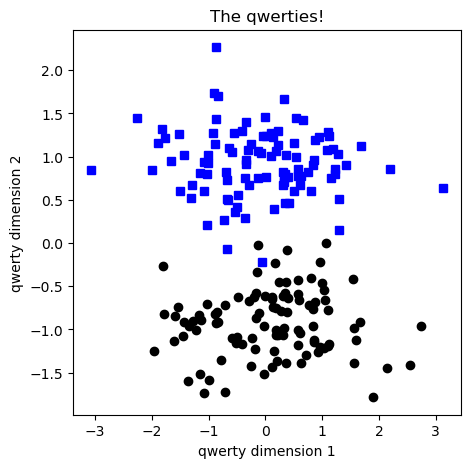

In [21]:
# create data

nPerClust = 100
blur = 1

A = [  1,  3 ]
B = [  1, -2 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix

# Combine data for standardization
all_data = np.hstack((a, b))

# Calculate mean and standard deviation
data_mean = np.mean(all_data, axis=1, keepdims=True)
data_std = np.std(all_data, axis=1, keepdims=True)
a_standardized = (a - data_mean) / data_std
b_standardized = (b - data_mean) / data_std

# Print some basic statistics
print("Original data statistics:")
print(f"a mean: {np.mean(a, axis=1)}")
print(f"a std: {np.std(a, axis=1)}")
print(f"b mean: {np.mean(b, axis=1)}")
print(f"b std: {np.std(b, axis=1)}")

print("\nStandardized data statistics:")
print(f"a_standardized mean: {np.mean(a_standardized, axis=1)}")
print(f"a_standardized std: {np.std(a_standardized, axis=1)}")
print(f"b_standardized mean: {np.mean(b_standardized, axis=1)}")
print(f"b_standardized std: {np.std(b_standardized, axis=1)}")

data_np = np.hstack((a_standardized,b_standardized)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [22]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=16, shuffle=True, drop_last=True) # Using batch size as 16

# Functions to build and train the model

In [23]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(2,16),  # input layer
      nn.ReLU(),        # activation unit
      nn.BatchNorm1d(16),  # batch normal
      nn.Linear(16,1),  # hidden layer
      nn.ReLU(),        # activation unit
                        # no need to add batch normal since we only got one activation
      nn.Linear(1,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [24]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  ANNmodel.train()
  # loop over epochs
  for epochi in range(numepochs):

    batchLoss = []
    for X, y in train_loader:
          
        # forward pass
        yHat = ANNmodel(X)
        
        # compute loss
        loss = lossfun(yHat, y)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss from this batch
        batchLoss.append(loss.item())
        
    losses[epochi] = np.mean(batchLoss)
  
  ANNmodel.eval()
  # final forward pass
  X, y = next(iter(test_loader))

  with torch.no_grad():
      yHat = ANNmodel(X)
  # compute the predictions and report accuracy
  # NOTE: Wasn't this ">0" previously?!?!
  totalacc = 100*torch.mean(((yHat>.5) == y).float())
  
  return losses,yHat,totalacc

# Test the new code by running it once

Final accuracy: 100%


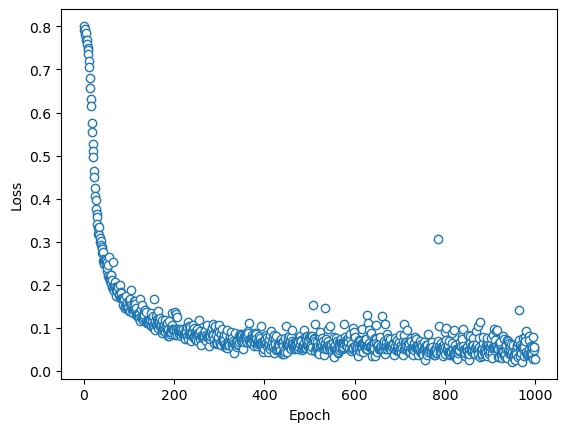

In [25]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)


# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

# Now for the real test (varying learning rates)

In [26]:
# learning rates
learningrates = np.linspace(.001,.1,50)

# initialize
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# the loop
for i,lr in enumerate(learningrates):
  
  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()


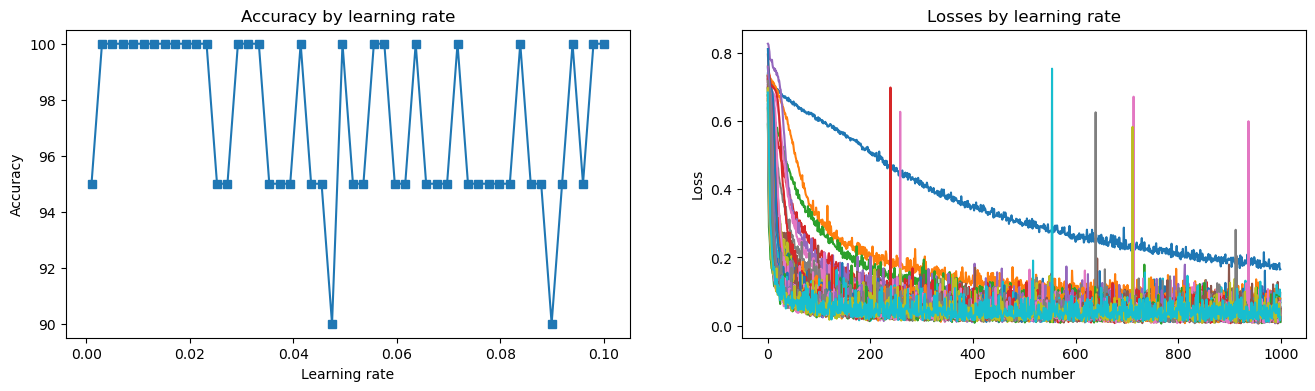

In [27]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [28]:
accByLR

[tensor(95.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(100.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(90.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(95.),
 tensor(95.),
 tensor(95.),
 tensor(100.),
 tensor(95.),
 tensor(95.),
 tensor(90.),
 tensor(95.),
 tensor(100.),
 tensor(95.),
 tensor(100.),
 tensor(100.)]

In [29]:
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(1.)

# Additional explorations

In [30]:
# 1) The code creates a model with 16 hidden units. Notice where the two "16"s appear when constructing the model. 
#    Recreate the model using 32 hidden units. Does that help with the issue of models getting stuck in local minima?
# 
# 2) Adjust the code to create two hidden layers. The first hidden layer should have 16 hidden units and the second 
#    hidden layer shuold have 32 units. What needs to change in the code to make the numbers match to prevent coding errors?
# 